In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
import numpy as np


def scheduler(T, s=0.008):
    f_t = lambda t: np.cos(((t/T + s) / (1 + s)) * (np.pi / 2)) ** 2
    alpha_bar_t = [1]
    beta = []
    for t in range(1, T+1):
        alpha_bar_t.append(f_t(t) / f_t(0))
        beta.append(np.clip(1 - (f_t(t) / f_t(t-1)), 0, 0.999))
    alpha_t = 1 - np.array(beta)

    return np.array(alpha_bar_t), alpha_t, np.array(beta)

# print(scheduler(10))

In [4]:
T = 1000
alpha_bar, alpha, beta = scheduler(T)

In [5]:
alpha_bar

array([1.00000000e+00, 9.99958716e-01, 9.99912576e-01, ...,
       9.71504404e-06, 2.42876691e-06, 3.74998224e-33])

In [ ]:
x = np.random.randint(1, T+1, size=32)
print(x)
print(alpha_bar[x])

[896  55 559 730 497 143 921 869 752 991 540 139  30 313 613  37 408 881
 408  71 163 381 274 926 191   5 635 748  67 977 840 450]
[2.60403738e-02 9.90546580e-01 4.02517394e-01 1.66852641e-01
 4.98519147e-01 9.45791653e-01 1.50815252e-02 4.11043232e-02
 1.42088657e-01 1.96717380e-04 4.31715288e-01 9.48583789e-01
 9.96652388e-01 7.70082457e-01 3.21739235e-01 9.95245233e-01
 6.35518999e-01 3.40013495e-02 6.35518999e-01 9.85073908e-01
 9.30800969e-01 6.75500564e-01 8.19127377e-01 1.32410892e-02
 9.07017653e-01 9.99745027e-01 2.90149311e-01 1.46469372e-01
 9.86555701e-01 1.28426866e-03 6.08986775e-02 5.71526677e-01]


In [6]:
def create_noisy_image(x: torch.Tensor, T: int, alpha_bar: np.array):
    steps = np.random.randint(1, T+1, size=x.size(0)) # generate random number ==> step
    alpha_bar_step = alpha_bar[steps]
    alpha_bar_t = torch.from_numpy(alpha_bar_step).reshape(-1, 1, 1, 1)
    noise = torch.randn_like(x)
    out = (alpha_bar_t ** 0.5) * x + ((1 - alpha_bar_t) ** 0.5) * noise
    return out, torch.from_numpy(steps), noise

In [7]:
def noisy_image_collate(x):
    # x ==> [(data1, label1), (data2, label2), ..., (data32, label32)]
    tensors, targets = zip(*x)
    tensors = [img.unsqueeze(0) for img in tensors]
    x_noisy, steps, noise = create_noisy_image(torch.cat(tensors, 0), T, alpha_bar)
    return [x_noisy.float(), steps, noise]

In [ ]:
batch_size = 32

train_dataset = datasets.FashionMNIST(root="./data", train=True, download=True,
                                      transform=ToTensor())

original_dloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
train_dloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=noisy_image_collate)

In [ ]:
next(iter(train_dloader))[2].size()

torch.Size([32, 1, 28, 28])

In [9]:
import matplotlib.pyplot as plt

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = images.squeeze(axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Original images


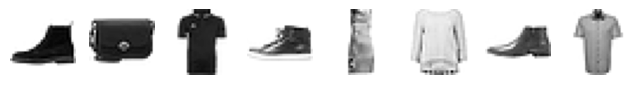

steps: [ 474  106  705  156  836  973   13 1000]
Noisy images


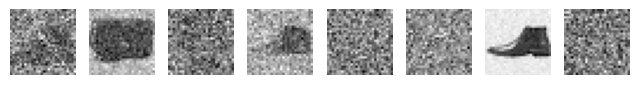

In [10]:
images, _ = next(iter(original_dloader))
print("Original images")
plot_multiple_images(images.permute(0, 2, 3, 1)[:8].detach().cpu().numpy())
plt.show()
noisy_img, steps, noise = create_noisy_image(images, T, alpha_bar)
print("steps:", steps[:8].detach().cpu().numpy())
print("Noisy images")
plot_multiple_images(noisy_img.permute(0, 2, 3, 1)[:8].detach().cpu().numpy())
plt.show()

In [11]:
class TimeEncoding(nn.Module):
    def __init__(self, T, embed_size, dtype=torch.float32):
        super().__init__()
        assert embed_size % 2 == 0, "embed_size must be even"

        p = torch.arange(T + 1).unsqueeze(1)
        i = torch.arange(0, embed_size, 2)
        t_emb = torch.zeros((T + 1, embed_size), dtype=dtype)
        t_emb[:, ::2] = torch.sin(p / 10_000 ** (i / embed_size))
        t_emb[:, 1::2] = torch.cos(p / 10_000 ** (i / embed_size))

        self.register_buffer('time_encodings', t_emb)

    def forward(self, inputs):
        return self.time_encodings[inputs]

time_embed = TimeEncoding(1000, 64)
time_embed([3, 12, 42]).size()

torch.Size([3, 64])

In [12]:
class SeperableConv2d(nn.Module):

    def __init__(self, in_channels: int, out_channels: int, *args, **kwargs):
        super().__init__()
        self.depthwise = nn.Conv2d(
            in_channels, in_channels, *args,  groups=in_channels, **kwargs)
        self.pointwise = nn.Conv2d(
            in_channels, out_channels, kernel_size=(1, 1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

model = SeperableConv2d(3, 64, kernel_size=(3, 3), padding=(1, 1))
x = torch.randn(size=(1, 3, 224, 224))
print(model(x).size())

torch.Size([1, 64, 224, 224])


In [13]:
class DiffusionModel(nn.Module):
    def __init__(self, T, embed_size):
        super().__init__()
        self.time_enc = TimeEncoding(T, embed_size)

        self.dim = 16

        self.conv1 = nn.Sequential(
            nn.ZeroPad2d(3),
            nn.Conv2d(1, self.dim, 3),
            nn.BatchNorm2d(self.dim),
            nn.ReLU()
        )
        self.adapt_time_enc = nn.Linear(embed_size, self.dim)

        self.skip_downsample = nn.ModuleList()
        self.down_sample = [16, 32, 64, 128]
        self.adapt_time_downsample = nn.ModuleList()

        for i in range(len(self.down_sample) - 1):
            module = nn.Sequential(
                nn.ReLU(),
                SeperableConv2d(self.down_sample[i], self.down_sample[i+1], kernel_size=(3, 3), padding=(1, 1)),
                nn.BatchNorm2d(self.down_sample[i+1]),
                nn.ReLU(),
                SeperableConv2d(self.down_sample[i+1], self.down_sample[i+1], kernel_size=(3, 3), padding=(1, 1)),
                nn.BatchNorm2d(self.down_sample[i+1]),
            )
            self.skip_downsample.append(module)
            self.adapt_time_downsample.append(nn.Linear(embed_size, self.down_sample[i+1]))

        self.skip_upsample = nn.ModuleList()
        self.up_sample = [128, 64, 32, 16]
        self.adapt_time_upsample = nn.ModuleList()

        for i in range(len(self.up_sample) - 1):
            if i == 0:
                module = nn.Sequential(
                    nn.ReLU(),
                    nn.ConvTranspose2d(self.up_sample[i], self.up_sample[i+1], kernel_size=(3, 3), padding=(1, 1)),
                    nn.BatchNorm2d(self.up_sample[i+1]),
                    nn.ReLU(),
                    nn.ConvTranspose2d(self.up_sample[i+1], self.up_sample[i+1], kernel_size=(3, 3), padding=(1, 1)),
                    nn.BatchNorm2d(self.up_sample[i+1]),
                    nn.Upsample(scale_factor=2)
                )
                self.skip_upsample.append(module)
                self.adapt_time_upsample.append(nn.Linear(embed_size, self.up_sample[i+1]))
            else:
                module = nn.Sequential(
                    nn.ReLU(),
                    nn.ConvTranspose2d(self.up_sample[i] + self.up_sample[i-1], self.up_sample[i+1], kernel_size=(3, 3), padding=(1, 1)),
                    nn.BatchNorm2d(self.up_sample[i+1]),
                    nn.ReLU(),
                    nn.ConvTranspose2d(self.up_sample[i+1], self.up_sample[i+1], kernel_size=(3, 3), padding=(1, 1)),
                    nn.BatchNorm2d(self.up_sample[i+1]),
                    nn.Upsample(scale_factor=2)
                )
                self.skip_upsample.append(module)
                self.adapt_time_upsample.append(nn.Linear(embed_size, self.up_sample[i+1]))

        self.cn_final = nn.Conv2d(self.down_sample[1] + self.up_sample[-1], 1, 3, padding=1)

    def forward(self, X_noisy, time_input):

        time_enc = self.time_enc(time_input)
        Z = self.conv1(X_noisy)
        time = self.adapt_time_enc(time_enc)
        Z = Z + time.unsqueeze(2).unsqueeze(3)

        cross_skips = []
        skip = Z

        for i, module in enumerate(self.skip_downsample):
            Z = module(Z)
            cross_skips.append(Z)
            # TODO: module registeration in init method!
            Z = nn.MaxPool2d(3, 2, 1).to(device)(Z)
            ## bottleneck
            # TODO: module registeration in init method!
            skip_link = nn.Conv2d(self.down_sample[i], self.down_sample[i+1], 1, stride=2).to(device)(skip)
            Z += skip_link
            time = self.adapt_time_downsample[i](time_enc)
            Z = Z + time.unsqueeze(2).unsqueeze(3)
            skip = Z

        for i, module in enumerate(self.skip_upsample):
            if i==0:
                Z = module(Z)
                ## bottleneck
                # TODO: module registeration in init method!
                skip_link = nn.Upsample(scale_factor=2).to(device)(skip)
                skip_link = nn.Conv2d(self.up_sample[i], self.up_sample[i+1], 1).to(device)(skip_link)
                Z += skip_link
                time = self.adapt_time_upsample[i](time_enc)
                Z = Z + time.unsqueeze(2).unsqueeze(3)
                Z = torch.cat([Z, cross_skips.pop()], axis=1)
                skip = Z
            else:
                Z = module(Z)
                ## bottleneck
                # TODO: module registeration in init method!
                skip_link = nn.Upsample(scale_factor=2).to(device)(skip)
                skip_link = nn.Conv2d(self.up_sample[i] + self.up_sample[i-1], self.up_sample[i+1], 1).to(device)(skip_link)
                Z += skip_link
                time = self.adapt_time_upsample[i](time_enc)
                Z = Z + time.unsqueeze(2).unsqueeze(3)
                Z = torch.cat([Z, cross_skips.pop()], axis=1)
                skip = Z
        Z = self.cn_final(Z)[:, :, 2:-2, 2:-2]
        return Z

# model = DiffusionModel(1000, 64)
# # X_noisy, step, _ = next(iter(train_dloader))
# X_noisy = torch.randn(32, 1, 28, 28)
# step = torch.randint(0, 1001, size=(32,))
# model(X_noisy.float(), step).size()

In [14]:
T = 1000
embed_size = 64
learning_rate = 0.001
epochs_num = 100

model = DiffusionModel(T, embed_size).to(device)
criterion = nn.L1Loss()
optimizer = torch.optim.NAdam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(epochs_num):
    print(f"Epoch{epoch}/{epochs_num}")
    for X_noisy, steps, noise in tqdm(train_dloader):
        X_noisy = X_noisy.to(device)
        steps = steps.to(device)
        noise = noise.to(device)
        prediction = model(X_noisy, steps)
        loss = criterion(prediction, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch0/100


100%|██████████| 1875/1875 [00:38<00:00, 48.20it/s]


Epoch1/100


100%|██████████| 1875/1875 [00:39<00:00, 47.45it/s]


Epoch2/100


100%|██████████| 1875/1875 [00:38<00:00, 48.13it/s]


Epoch3/100


100%|██████████| 1875/1875 [00:38<00:00, 48.16it/s]


Epoch4/100


100%|██████████| 1875/1875 [00:39<00:00, 47.82it/s]


Epoch5/100


100%|██████████| 1875/1875 [00:38<00:00, 48.54it/s]


Epoch6/100


100%|██████████| 1875/1875 [00:38<00:00, 48.45it/s]


Epoch7/100


100%|██████████| 1875/1875 [00:38<00:00, 48.78it/s]


Epoch8/100


100%|██████████| 1875/1875 [00:38<00:00, 48.31it/s]


Epoch9/100


100%|██████████| 1875/1875 [00:39<00:00, 47.72it/s]


Epoch10/100


100%|██████████| 1875/1875 [00:40<00:00, 46.69it/s]


Epoch11/100


100%|██████████| 1875/1875 [00:38<00:00, 48.79it/s]


Epoch12/100


100%|██████████| 1875/1875 [00:39<00:00, 47.05it/s]


Epoch13/100


100%|██████████| 1875/1875 [00:40<00:00, 46.72it/s]


Epoch14/100


100%|██████████| 1875/1875 [00:39<00:00, 46.92it/s]


Epoch15/100


100%|██████████| 1875/1875 [00:42<00:00, 43.99it/s]


Epoch16/100


100%|██████████| 1875/1875 [00:39<00:00, 47.21it/s]


Epoch17/100


100%|██████████| 1875/1875 [00:39<00:00, 47.83it/s]


Epoch18/100


100%|██████████| 1875/1875 [00:41<00:00, 45.08it/s]


Epoch19/100


100%|██████████| 1875/1875 [00:39<00:00, 47.42it/s]


Epoch20/100


100%|██████████| 1875/1875 [00:39<00:00, 47.97it/s]


Epoch21/100


100%|██████████| 1875/1875 [00:39<00:00, 47.69it/s]


Epoch22/100


100%|██████████| 1875/1875 [00:38<00:00, 48.55it/s]


Epoch23/100


100%|██████████| 1875/1875 [00:38<00:00, 48.47it/s]


Epoch24/100


100%|██████████| 1875/1875 [00:38<00:00, 48.12it/s]


Epoch25/100


100%|██████████| 1875/1875 [00:39<00:00, 47.84it/s]


Epoch26/100


100%|██████████| 1875/1875 [00:38<00:00, 48.67it/s]


Epoch27/100


100%|██████████| 1875/1875 [00:39<00:00, 47.89it/s]


Epoch28/100


100%|██████████| 1875/1875 [00:38<00:00, 48.38it/s]


Epoch29/100


100%|██████████| 1875/1875 [00:38<00:00, 48.57it/s]


Epoch30/100


100%|██████████| 1875/1875 [00:39<00:00, 47.97it/s]


Epoch31/100


100%|██████████| 1875/1875 [00:38<00:00, 49.04it/s]


Epoch32/100


100%|██████████| 1875/1875 [00:38<00:00, 48.37it/s]


Epoch33/100


100%|██████████| 1875/1875 [00:39<00:00, 47.00it/s]


Epoch34/100


100%|██████████| 1875/1875 [00:38<00:00, 48.62it/s]


Epoch35/100


100%|██████████| 1875/1875 [00:38<00:00, 48.34it/s]


Epoch36/100


100%|██████████| 1875/1875 [00:38<00:00, 48.36it/s]


Epoch37/100


100%|██████████| 1875/1875 [00:39<00:00, 47.58it/s]


Epoch38/100


100%|██████████| 1875/1875 [00:39<00:00, 47.63it/s]


Epoch39/100


100%|██████████| 1875/1875 [00:40<00:00, 46.59it/s]


Epoch40/100


100%|██████████| 1875/1875 [00:40<00:00, 46.55it/s]


Epoch41/100


100%|██████████| 1875/1875 [00:39<00:00, 47.68it/s]


Epoch42/100


100%|██████████| 1875/1875 [00:38<00:00, 48.09it/s]


Epoch43/100


100%|██████████| 1875/1875 [00:38<00:00, 48.57it/s]


Epoch44/100


100%|██████████| 1875/1875 [00:39<00:00, 47.90it/s]


Epoch45/100


100%|██████████| 1875/1875 [00:41<00:00, 44.90it/s]


Epoch46/100


100%|██████████| 1875/1875 [00:39<00:00, 46.97it/s]


Epoch47/100


100%|██████████| 1875/1875 [00:38<00:00, 48.47it/s]


Epoch48/100


100%|██████████| 1875/1875 [00:38<00:00, 48.10it/s]


Epoch49/100


100%|██████████| 1875/1875 [00:40<00:00, 46.31it/s]


Epoch50/100


100%|██████████| 1875/1875 [00:39<00:00, 47.36it/s]


Epoch51/100


100%|██████████| 1875/1875 [00:38<00:00, 48.69it/s]


Epoch52/100


100%|██████████| 1875/1875 [00:38<00:00, 48.29it/s]


Epoch53/100


100%|██████████| 1875/1875 [00:38<00:00, 48.69it/s]


Epoch54/100


100%|██████████| 1875/1875 [00:38<00:00, 48.89it/s]


Epoch55/100


100%|██████████| 1875/1875 [00:38<00:00, 48.69it/s]


Epoch56/100


100%|██████████| 1875/1875 [00:39<00:00, 48.01it/s]


Epoch57/100


100%|██████████| 1875/1875 [00:38<00:00, 48.38it/s]


Epoch58/100


100%|██████████| 1875/1875 [00:39<00:00, 48.02it/s]


Epoch59/100


100%|██████████| 1875/1875 [00:39<00:00, 47.22it/s]


Epoch60/100


100%|██████████| 1875/1875 [00:39<00:00, 47.81it/s]


Epoch61/100


100%|██████████| 1875/1875 [00:39<00:00, 47.04it/s]


Epoch62/100


 77%|███████▋  | 1436/1875 [00:29<00:09, 48.16it/s]


KeyboardInterrupt: 

In [ ]:
def generate(model, batch_size=32, device="cuda"):
    model.eval()
    X = torch.randn(batch_size, 1, 28, 28, device=device)
    for t in range(T - 1, 0, -1):
        print(f"\rt = {t}", end=" ")  # extra code – show progress
        noise = (torch.randn if t > 1 else torch.zeros)(X.shape).to(device)
        predicted_noise = model(X, torch.tensor([t] * batch_size, device=device))
        X = (
            1 / alpha[t] ** 0.5
            * (X - beta[t] / (1 - alpha_bar[t]) ** 0.5 * predicted_noise)
            + (1 - alpha[t]) ** 0.5 * noise
        )
    return X

torch.cuda.manual_seed(42)
X_gen = generate(model, batch_size=3)

t = 1 

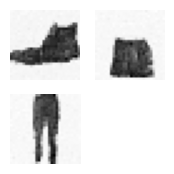

In [ ]:
plot_multiple_images(X_gen.permute(0, 2, 3, 1).detach().cpu().numpy(), 2)